In [1]:
from cil.framework import BlockDataContainer
from cil.optimisation.functions import TotalVariation, SmoothMixedL21Norm, OperatorCompositionFunction, L2NormSquared, BlockFunction, ZeroFunction, MixedL21Norm, LeastSquares
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, FISTA, GD
import sirf.Gadgetron as mr
from sirf.Utilities import examples_data_path
import os
import matplotlib.pyplot as plt
import numpy
from cil.utilities.display import show2D
from tqdm.auto import tqdm
import brainweb

In [2]:
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")


def crop_and_fill(templ_im, vol):
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim_orig = templ_im.as_array().shape
    idim = (1,)*(3-len(idim_orig)) + idim_orig
    offset = (numpy.array(vol.shape) - numpy.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.copy()
    
    # Fill image content 
    templ_im_out.fill(numpy.reshape(vol, idim_orig))
    return(templ_im_out)

In [3]:
# 1. create MR AcquisitionData
mr_acq = mr.AcquisitionData(examples_data_path('MR') + '/grappa2_1rep.h5')

In [4]:
# 2. calculate CSM
preprocessed_data = mr.preprocess_acquisition_data(mr_acq)
preprocessed_data.sort()

csm = mr.CoilSensitivityData()
csm.smoothness = 50
csm.calculate(preprocessed_data)

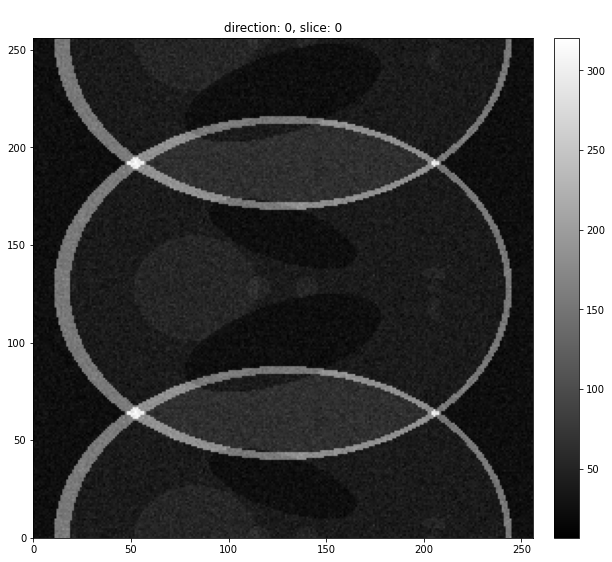

(1, 256, 256)


In [5]:
# 3. calculate image template
recon = mr.FullySampledReconstructor()
recon.set_input(preprocessed_data)
recon.process()
im_mr = recon.get_output()
show2D(im_mr.abs())
print(im_mr.shape)

In [6]:
# 4. create AcquisitionModel
acq_mod_mr = mr.AcquisitionModel(preprocessed_data, im_mr)

# Supply csm to the acquisition model 
acq_mod_mr.set_coil_sensitivity_maps(csm)

In [7]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

In [8]:
for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

In [9]:
T1_arr = vol['T1']

<Figure size 432x288 with 0 Axes>

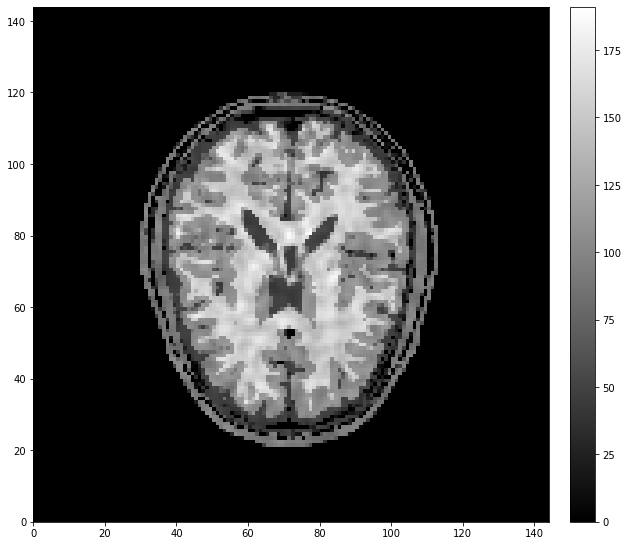

In [10]:
# Display it
plt.figure();
slice_show = T1_arr.shape[0]//2
# plot_2d_image([1,3,2], T1_arr[slice_show, 100:-100, 100:-100], 'T1', cmap="Greys_r")
show2D(T1_arr[slice_show, 100:-100, 100:-100])

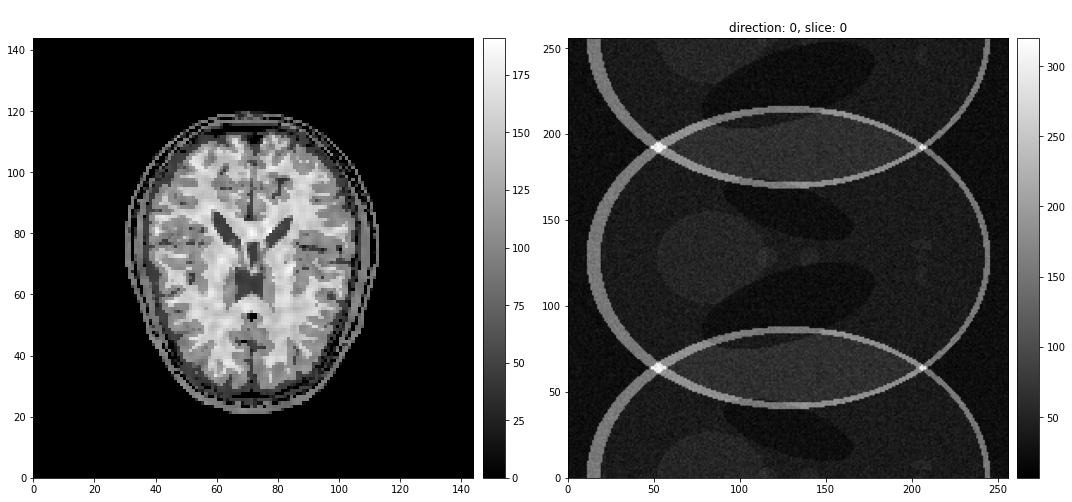

(127, 344, 344) (1, 256, 256)


In [11]:
show2D([T1_arr[slice_show, 100:-100, 100:-100], im_mr.abs()])
print(T1_arr.shape, im_mr.shape )

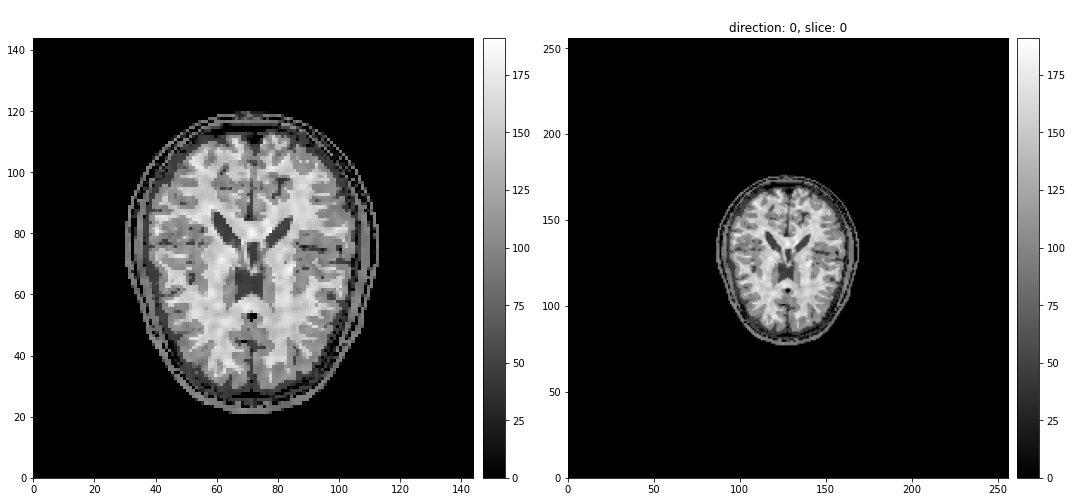

In [12]:
im_mr = crop_and_fill(im_mr, T1_arr)
show2D([T1_arr[slice_show, 100:-100, 100:-100], im_mr.abs()])

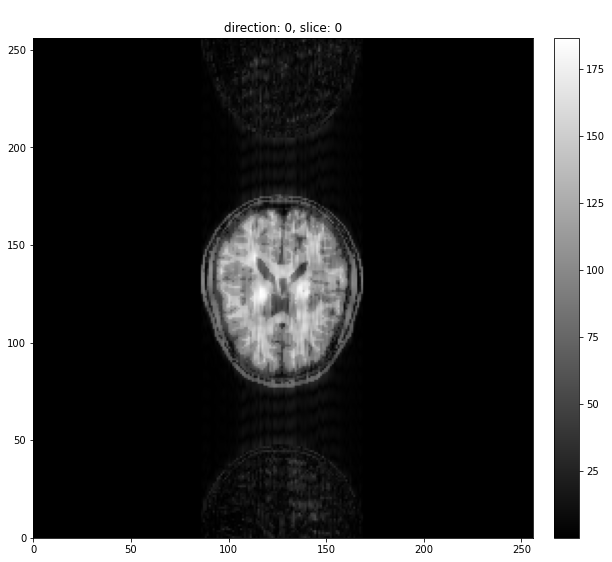

In [13]:
raw_mr = acq_mod_mr.forward(im_mr)
bwd_mr = acq_mod_mr.backward(raw_mr)
show2D(bwd_mr.abs())

In [14]:
init_image = bwd_mr

# FISTA (with TV)

In [15]:
f = LeastSquares(acq_mod_mr, raw_mr)
alpha = 20
g = alpha * TotalVariation(max_iteration=10)
fista = FISTA(initial=init_image, f=f, g=g, max_iteration=50, update_objective_interval=1)
fista.run(verbose=0)

FISTA setting up
FISTA configured
Initialised GradientOperator with numpy backend


/home/sirf/build_vaggelis/INSTALL/python/cil/optimisation/operators/GradientOperator.py:98: UserWarning: Warning: Complex geometries will use `numpy` backend
  warnings.warn("Warning: Complex geometries will use `numpy` backend")


# PDHG-Implicit (with TV)

In [16]:
F = L2NormSquared(b=raw_mr)
K = acq_mod_mr
G = g

normK = K.norm()
sigma = 1./normK
tau = 1./normK

pdhg_implicit= PDHG(initial=init_image, f = F, g = G, operator = K, 
            max_iteration = 50, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_implicit.run(verbose=0)

PDHG setting up
PDHG configured


# PDHG-Explicit (with TV)

In [17]:
Grad = GradientOperator(bwd_mr)
f2 = alpha * MixedL21Norm()

# there is a problem with scaled function and proximal_conjugate
# override it's proximal conjugate
def proximal_conjugate(x, tau, out=None):
    
    if out is not None:
        
        res1_tmp = x/(((x/alpha).pnorm(2)).maximum(1.0))
        out.fill(res1_tmp)
            
f2.proximal_conjugate = proximal_conjugate

f1 = L2NormSquared(b=raw_mr)
F = BlockFunction(f1, f2)
K = BlockOperator(acq_mod_mr, Grad)
G = ZeroFunction() 

normK = K.norm()
sigma = 1./normK
tau = 1./normK

pdhg_explicit= PDHG(initial=init_image, f = F, g = G, operator = K, 
            max_iteration = 50, sigma=sigma, tau=tau,
            update_objective_interval = 1)
pdhg_explicit.run(verbose=0)

Initialised GradientOperator with numpy backend
PDHG setting up
PDHG configured


# GD + (with _smooth_ TV)

In [18]:
# gradient descent

smoothTV = alpha * SmoothMixedL21Norm(epsilon=1e-1)
Grad = GradientOperator(init_image)

gd_obj = LeastSquares(acq_mod_mr, raw_mr) + OperatorCompositionFunction(smoothTV, Grad)
step_size = 0.01
gd = GD(initial=init_image, objective_function = gd_obj, step_size=step_size, 
        max_iteration=200, update_objective_interval=1)
gd.run(verbose=0)

Initialised GradientOperator with numpy backend
GD setting up
GD configured


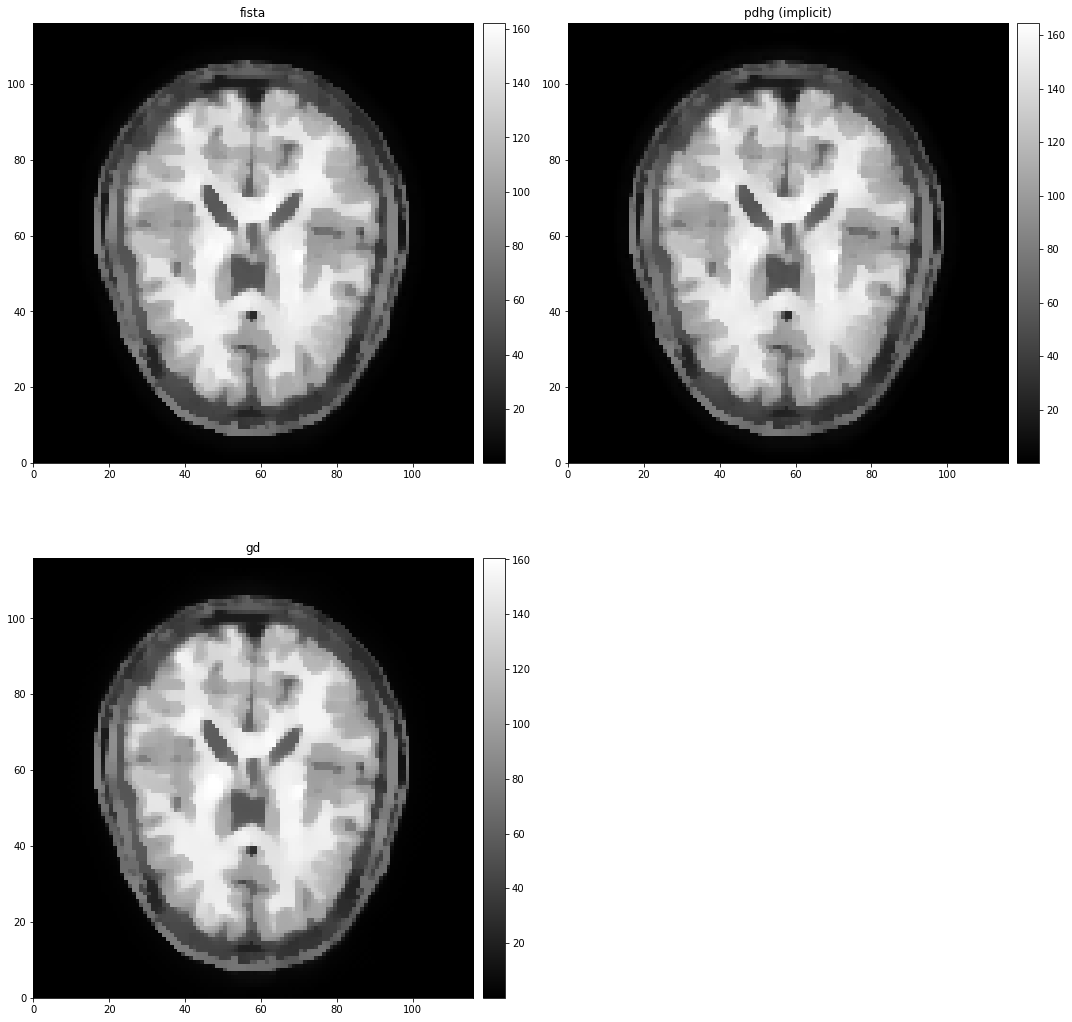

/home/xqg84736/miniconda3/envs/cil_with_sirf/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


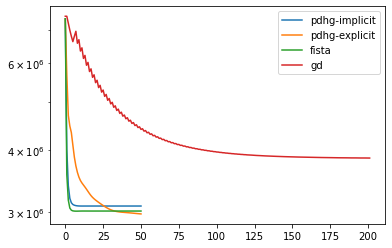

In [19]:
show2D([fista.solution.abs().as_array()[0,70:-70,70:-70],
        pdhg_implicit.solution.abs().as_array()[0,70:-70,70:-70],
        gd.solution.abs().as_array()[0,70:-70,70:-70]], 
      title = ['fista','pdhg (implicit)','gd', 'pdhg (explicit)'])

plt.figure()
plt.semilogy(pdhg_implicit.objective, label='pdhg-implicit')
plt.semilogy(pdhg_explicit.objective, label='pdhg-explicit')
plt.semilogy(fista.objective, label='fista')
plt.semilogy(gd.objective, label='gd')
plt.legend()
plt.show()